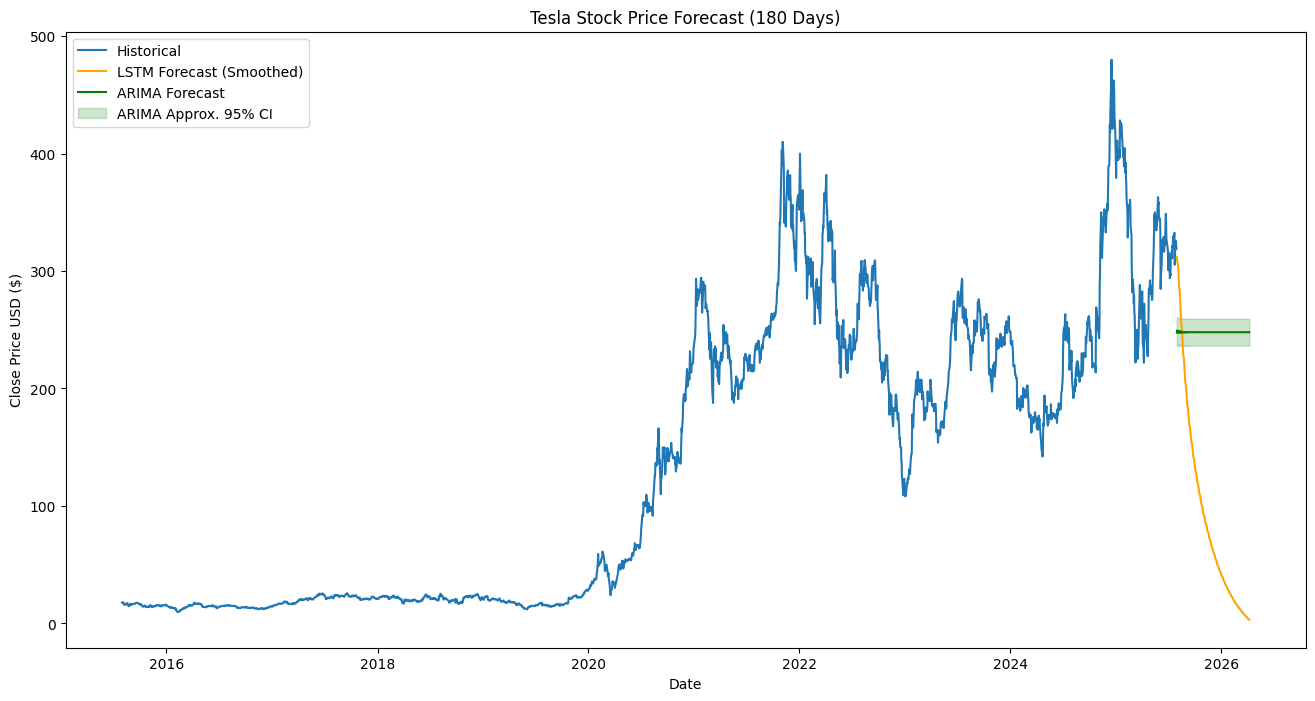

Forecasted 180-day return: -0.9898950181745502
Annualized forecasted return (smoothed): -0.9983917641038151
Forecasted annual return saved to 'models/tsla_forecast_return.pkl'


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pickle

# -------------------------------
# 1. Load Tesla dataset
# -------------------------------
df = pd.read_csv("../data/TSLA.csv", parse_dates=['Date'])
df = df.sort_values('Date')
data = df.filter(['Close']).values  # shape: (n_samples,1)

# -------------------------------
# 2. Load saved models
# -------------------------------
lstm_model = load_model("models/lstm_model.h5")

with open("models/arima_model.pkl", "rb") as f:
    arima_model = pickle.load(f)

# -------------------------------
# 3. Forecast parameters
# -------------------------------
forecast_period = 180  # change to 180–365 as needed
sequence_length = 60   # same as used during LSTM training

# -------------------------------
# 4. Scale data for LSTM
# -------------------------------
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)  # shape: (n_samples,1)

# -------------------------------
# 5. Prepare last sequence for LSTM
# -------------------------------
last_sequence = scaled_data[-sequence_length:]  # shape: (60,1)
lstm_input = last_sequence.reshape(1, sequence_length, 1)  # shape: (1,60,1)

lstm_forecast_scaled = []

# -------------------------------
# 6. Rolling forecast for LSTM
# -------------------------------
for _ in range(forecast_period):
    pred = lstm_model.predict(lstm_input, verbose=0)  # shape: (1,1)
    lstm_forecast_scaled.append(pred[0,0])
    
    # reshape prediction to 3D: (1,1,1)
    pred_reshaped = pred.reshape(1,1,1)
    
    # slide window: drop first timestep, append new prediction
    lstm_input = np.concatenate((lstm_input[:,1:,:], pred_reshaped), axis=1)

# Convert to original scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1,1))

# -------------------------------
# 7. Smooth LSTM forecast to avoid extreme values
# -------------------------------
window_size = 5  # simple moving average
lstm_forecast_smooth = pd.Series(lstm_forecast.flatten()).rolling(window=window_size, min_periods=1).mean().values.reshape(-1,1)

# -------------------------------
# 8. ARIMA forecast
# -------------------------------
arima_forecast = arima_model.forecast(steps=forecast_period)
residuals = arima_model.resid
std_resid = residuals.std()
arima_conf_lower = arima_forecast - 1.96*std_resid
arima_conf_upper = arima_forecast + 1.96*std_resid

# -------------------------------
# 9. Generate forecast dates
# -------------------------------
last_date = df['Date'].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1),
                               periods=forecast_period, freq='B')  # business days

# -------------------------------
# 10. Plot forecasts
# -------------------------------
plt.figure(figsize=(16,8))
plt.plot(df['Date'], df['Close'], label='Historical')
plt.plot(forecast_dates, lstm_forecast_smooth, label='LSTM Forecast (Smoothed)', color='orange')
plt.plot(forecast_dates, arima_forecast, label='ARIMA Forecast', color='green')
plt.fill_between(forecast_dates,
                 arima_conf_lower,
                 arima_conf_upper,
                 color='green', alpha=0.2,
                 label='ARIMA Approx. 95% CI')
plt.title(f'Tesla Stock Price Forecast ({forecast_period} Days)')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

# -------------------------------
# 11. Compute forecasted return
# -------------------------------
start_price = lstm_forecast_smooth[0, 0]
end_price = lstm_forecast_smooth[-1, 0]

# Cumulative return over forecast_period
forecasted_return = (end_price / start_price) - 1
print(f"Forecasted {forecast_period}-day return:", forecasted_return)

# Annualized return (252 trading days)
forecasted_return_annual = (1 + forecasted_return) ** (252 / forecast_period) - 1
print("Annualized forecasted return (smoothed):", forecasted_return_annual)

# -------------------------------
# 12. Save forecasted return for Task-4
# -------------------------------
with open("models/tsla_forecast_return.pkl", "wb") as f:
    pickle.dump(forecasted_return_annual, f)
    
print(f"Forecasted annual return saved to 'models/tsla_forecast_return.pkl'")